# Lab 03 : Schrödinger Equation

## Objectives

In this lab we will solve the Schrödinger equation as an eigenvalue problem.

Much of the preparation for this lab was discussed in the homework.  **You must understand and complete the homework to proceed!**  In fact, once you have completed the homework we can just apply those results to arbitrary potentials.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [1]:
### BEGIN SOLUTION
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
import scipy.interpolate as interp
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
### END SOLUTION

## Schrödinger Equation

The homework contains a more thorough discussion of how we will set up and solve the Schrödinger equation.  Here we summarize the important points.

The Schrödinger equation written in operator form, $\hat H\psi(x) = E\psi(x)$, can be converted to matrix form, $\mathsf{H}\vec\psi = E\vec\psi$, in the nonrelativistic case if we discretize the second derivative.  As we saw in the homework, the matrix $\mathsf{H}$ is a symmetric, tridiagonal matrix and this eigenvalue problem can be solved using `scipy.linalg.eig_banded`.  We also saw how to renormalize the eigenvectors (or wavefunctions) to be consistent with the normalization condition from quantum mechanics.  We will use the work from the homework as our starting point.  **Make sure you understand the setup from the homework prior to working on the lab.**

Using the code you wrote in the homework, write a function to construct the matrix $\mathsf{H}$ in banded form as used by scipy.linalg.eig_banded. Your function should work for arbitrary $N$, length $L$, and potential $V(x)$. Recall that we would like to evaluate the wavefunction at $N+1$ points, and so the step-size will be $h = L/N$. Write your function for constructing the Hamiltonian matrix below.

(*Note: There are some elements of the matrix that are not used by the algorithm. It is best to fill these in anyway. In fact, it is easier to construct the matrix by not treating these elements as special. Since the values do not matter, just fill them in along with the rest of the band in which they fall.*)

In [2]:
def Hamiltonian (N, L, V) :
### BEGIN SOLUTION
    """
    Calculate the Hamiltonian as a banded matrix for use with
    scipy.linag.eig_banded at N+1 points on the interval [0,L]
    and with potential V(x).
    Inputs:
      N : Number of segments in the interval.  The Hamiltonian
          will be calculated at N+1 points.
      L : Length of the interval over which the Hamiltonian is calculated.
      V : function : Potential. This is called as V(x).
    Outputs :
      H : two dimensional array formatted for use with scipy.linalg.eig_banded.
    """
    x = np.linspace(0, L, N+1)
    # Strictly, we should use np.diff to get the differences between
    # the x values we just calculated.  Instead, we will calculate an
    # "approximate" h, which will be sufficient for us.
    # We want this to be floating point division.  Since Python3
    # already does that, we do not need to do anything special.
    h = L / N
    H = np.zeros((2,N+1))
    H[0] = -1./(2*h**2)
    H[1] = 1./h**2 + V(x)
    return H
### END SOLUTION

## Infinite Square Well

As always we begin by solving a problem with a known solution.  One of the first problems we solve in quantum mechanics is a single particle in an infinite square well.  Here $V(x)=0$ for $0<x<L$ and is infinite outside this region.  Where the potential is infinite the wave function must be zero.  This means $\psi(x)=0$ for $x\le 0$ and $x\ge L$ and we only need to solve for $\psi(x)$ on the finite interval $0<x<L$.  In other words, this problem is described quite well by the matrix form we derived in the homework.

To proceed we will let $L=1$ and discretize the region using 1001 equally spaced points ($N=1000$ equal length segments).  We can almost use the `Hamiltonian` function you copied from the homework, but with a small detail.  The boundary conditions we have for the infinite square well are that $\psi(0) = \psi(L) = 0$.  In the discrete version this means $\psi_0 = \psi_N = 0$ where $N$ is the number of segments.  In our function from the homework we required $\psi_{-1}=\psi_{N+1}=0$ so we need to make a small change.  One way to proceed is to solve for the wave function at $\{ x_1, x_2, \ldots, x_{N-1} \}$.  In other words, do not solve for $\psi_0=\psi(x_0)$ or $\psi_N=\psi(x_N)$ since we already know they must be zero and *by construction they will be zero*!  Stop and think about this, it is a simple idea but can be confusing.  Effectively this just reduces the size of the matrix $\mathsf{H}$ and changes the points at which the eigenvectors will been evaluated.

Construct the matrix $\mathsf{H}$ for the infinite square well using the parameters from above.  As stated above, the Hamiltonian we construct is not quite right.  But we can get the one we want *without changing the `Hamiltonian` function*.  We just want to not use the first and last columns of the matrix it returns.  This sounds like a job for array slicing!

Another issue is that we need to provide a function, the potential, to `Hamiltonian`.  What function should we use and how should we specify it?

Solve the eigenvalue problem using `scipy.linalg.eig_banded`.  Save the eigenvalues and the eigenvectors.  Renormalize the eigenvectors to produce the wave function, $\vec\psi$, using the normalization from quantum mechanics.  Provide the code for doing all of this below.

In [4]:
### BEGIN SOLUTION
N = 1000
L = 1
H = Hamiltonian(N, L, lambda x : 0)
# Solve for eigenvalues and eigenvectors.
# Slice out everything between the first and last columns
(E, B) = la.eig_banded(H[:,1:-1])
# We need the stepsize for the normalization
h = L / N
# Wave functions need to be renormalized
psi = B / np.sqrt(h)
### END SOLUTION

### Testing the Eigenvalues

The eigenvalues are the allowed energies of the particle.  For the infinite square well using the units we have chosen these can be written as

$$ E_n = \frac{n^2 \pi^2}{2 L^2}, $$

where $n$ is an integer with $n\ge1$.

Calculate the fractional error in the first three eigenvalues.  Print these values below.  You should find the calculated eigenvalues have fractional errors less than $10^{-5}$. (*Note:* If you errors are larger than this then something is wrong!  A possible error comes from not correctly implementing the boundary conditions as discussed above; effectively solving the eigenvalue problem at too many points.)

In [5]:
### BEGIN SOLUTION
n = np.arange(1,N)
x = n * h
En = n**2*np.pi**2 /(2*L**2)
ferr = np.abs(1 - E/En)
print("Fractional errors in first three eigenvalues")
for j in range(3) :
    print(f"E{j+1} : {ferr[j]}")
### END SOLUTION

Fractional errors in first three eigenvalues
E1 : 8.224404282053399e-07
E2 : 3.2898571902251206e-06
E3 : 7.402178426763051e-06


### Testing the Eigenvectors

For the infinite square well we also know the eigenvectors.  The eigenvectors are given by

$$ \psi_n(x) = \sqrt{\frac{2}{L}} \sin\left( \frac{n\pi x}{L} \right). $$

Produce a nice figure including the first three eigenvectors you have calculated along with the known solutions.  In doing so keep the following in mind.
1. Mathematically both $\vec\psi$ and $-\vec\psi$ are solutions to the eigenvalue problem.  The form of the analytic solution given above is the "positive" eigenvector; it is an increasing function from $x=0$, not a decreasing function.  The algorithm for calculating the eigenvectors can return vectors with either sign so some of them may need to be modified.  This can be done in a simple, general manner, how? (*Hint:* The `sign` function can make this easy.)
2. There are a lot of quantities being plotted in this single figure.  How do we make the figure easy to read?
3. The calculated eigenvectors should be in very good agreement with the analytic ones.

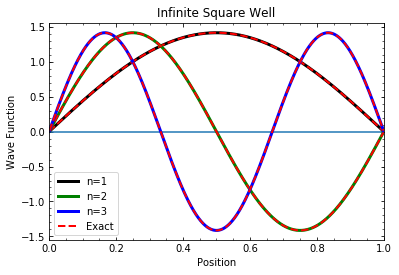

In [6]:
### BEGIN SOLUTION
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(0)
ax.plot(x, np.sign(psi[0,0])*psi[:,0], 'k-', lw=3, label='n=1')
ax.plot(x, np.sqrt(2./L) * np.sin(np.pi*x/L), 'r--', lw=2)
ax.plot(x, np.sign(psi[0,1])*psi[:,1], 'g-', lw=3, label='n=2')
ax.plot(x, np.sqrt(2./L) * np.sin(2*np.pi*x/L), 'r--', lw=2)
ax.plot(x, np.sign(psi[0,2])*psi[:,2], 'b-', lw=3, label='n=3')
ax.plot(x, np.sqrt(2./L) * np.sin(3*np.pi*x/L), 'r--', lw=2, label='Exact')
ax.set_xlabel('Position')
ax.set_ylabel('Wave Function')
ax.set_title('Infinite Square Well')
ax.legend(loc='lower left')
ax.set_xlim(0, 1);
### END SOLUTION

## General Potential

Now that we know how to solve the Schrödinger equation as an eigenvalue problem we can apply it to any potential.  As another example we will consider a particle in the potential

$$ V(x) = \left\{
\begin{array}{ll}
\infty, & x \le 0 \\
0, & 0 < x \le a_0 \\
V_0 \left[ 1 - \left(\frac{\beta-x}{\beta-a_0}\right)^2 \right], & a_0 < x \le a_1 \\
V_1 + \gamma (x-a_1), & a_1 < x \le a_2 \\
V_2, & x > a_2
\end{array}
\right. .$$

It would be quite tedious to try to analytically solve the Schrödinger equation with this potential so we will instead solve it numerically.

For our problem we will choose $\beta=9 a_0/8$, $V_0=150$, $V_1=30$, $V_2=80$, $a_0=1$, $a_2=1.75$. We can show that $a_1=\beta+(\beta-a_0)\sqrt{1-V_1/V_0}$ and that $\gamma = (V_2-V_1)/(a_2-a_1)$.  For your convenience this potential is implemented below.  Note that it is written so that it works for `x` given either as a single number or an (arbitrarily dimensioned) array.  We achieve this by using array slicing with indices from the `where` function, instead of using a bunch of `if` statements.  (This also could be done using boolean arrays.)

In [7]:
def potential(x) :
    """
    Potential as defined above.
    x may be a single number or an array.
    """
    # We need x to be an array of at least 1 dimension
    x = np.atleast_1d(x)
    V = np.zeros_like(x)
    # Constants for our particular problem
    V0 = 150.
    V1 = 30.
    V2 = 80.
    a0 = 1.
    a2 = 1.75
    beta = 9*a0/8.
    delta = 1./(beta-a0)**2
    a1 = beta + (beta-a0)*np.sqrt(1.-V1/V0)
    gamma = (V2-V1) / (a2-a1)
    # For x <= a0 the potential is zero.  This was initialized when constructing V.
    # For a0 < x <= a1 the potential is a quadratic.
    ind = np.where((x>a0) & (x<=a1))
    V[ind] = V0*(1-delta*(beta-x[ind])**2)
    # For a1 < x <= a2 the potential is a line.
    ind = np.where((x>a1) & (x<=a2))
    V[ind] = V1 + gamma*(x[ind]-a1)
    # For x > a2 the potential is the constant V2.
    ind = np.where(x>a2)
    V[ind] = V2
    return V

Make a "somewhat nice" plot of the potential to see what it looks like.  Produce a plot for $0<x\le 3 a_0$.  Your figure should include horizontal lines for the potential values $V_0$, $V_1$, and $V_2$.  It should also include vertical lines for $a_0$, $a_1$, and $a_2$.  Though not required, you can label all these lines in your plot using `ax.text` to place text in appropriate locations.

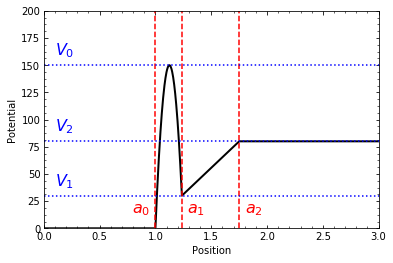

In [8]:
### BEGIN SOLUTION
V0 = 150.
V1 = 30.
V2 = 80.
a0 = 1.
a2 = 1.75
beta = 9*a0/8.
gamma = 1./(beta-a0)**2
a1 = beta + (beta-a0)*np.sqrt(1.-V1/V0)
x = np.linspace(0, 3*a0, 1000)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, potential(x), 'k-', lw=2)
ax.axvline(a0, color='r', ls='--')
ax.axvline(a1, color='r', ls='--')
ax.axvline(a2, color='r', ls='--')
ax.axhline(V0, color='b', ls=':')
ax.axhline(V1, color='b', ls=':')
ax.axhline(V2, color='b', ls=':')
ax.set_ylim(top=V0+50)
ax.set_xlabel('Position')
ax.set_ylabel('Potential')
ax.set_xlim(0, 3*a0)
ax.set_ylim(0, V0+50)
# Add nice labels
ax.text(0.1, V0+5, '$V_0$', ha='left', va='bottom', fontsize=16, color='b')
ax.text(0.1, V1+5, '$V_1$', ha='left', va='bottom', fontsize=16, color='b')
ax.text(0.1, V2+5, '$V_2$', ha='left', va='bottom', fontsize=16, color='b')
ax.text(a0-0.05, 10, '$a_0$', ha='right', va='bottom', fontsize=16, color='r')
ax.text(a1+0.05, 10, '$a_1$', ha='left', va='bottom', fontsize=16, color='r')
ax.text(a2+0.05, 10, '$a_2$', ha='left', va='bottom', fontsize=16, color='r')
ax.minorticks_on()
### END SOLUTION

Now that we see what the potential looks like we can solve the Schrödinger equation.  We can mostly proceed as in the infinite square well case.  Since the potential is infinite for $x\le0$ we again have the boundary condition $\psi(0)=0$.  Unfortunately we do not have a physical cutoff at large $x$ so we will impose one by hand.  Choose $\psi(x)=0$ for $x\ge 5a_0$.  We will again use 1000 segments (1001 points) in the numerical solution.

Before performing any calculation you should think about the expected behavior of the solution.  If you are familiar with quantum mechanics you can *and should* determine what you expect the wave functions to look like when the energy of the particle is in each of the four regimes: $0<E<V_1$, $V_1<E<V_2$, $V_2<E<V_0$, and $E>V_0$.  We will not study all of these cases in detail but we will have solutions in each region and these solutions should meet our expectations.  It can be helpful to have an idea of how the answer should behave before you do a calculation, as this will help us determine if our solutions make sense.

Construct the matrix $\mathsf{H}$ for this potential using the parameters from above.  Solve the eigenvalue problem using `scipy.linalg.eig_banded`.  Save the eigenvalues and the eigenvectors.  Renormalize the eigenvectors to produce the wave function, $\vec\psi$, using the normalization from quantum mechanics.  Provide the code for doing all of this below.

In [9]:
### BEGIN SOLUTION
N = 1000
a0 = 1.
L = 5. * a0
h = L / N
H = Hamiltonian(N, L, potential)
# Solve for eigenvalues and eigenvectors
# Remove the two end points.
(E, B) = la.eig_banded(H[:,1:-1])
# Wave functions need to be renormalized
psi = B / np.sqrt(h)
### END SOLUTION

### Bound states:

Classically a particle will be bound in this potential if it has $E<V_2$ or if $E<V_0$ and $x<\beta$.  This means that classically we can have a particle bound in either of the two “wells” that should appear in your plot of the potential above.  Quantum mechanically this is not the case.  **Quantum mechanically the only states that will be bound are those with $E<V_2$.**

Print the number of quantum mechanically bound states for this potential.  This should be a relatively small number, we are going to look at all of them in more detail.  (No, you do not need to, nor should you, count them by hand!)

In [10]:
### BEGIN SOLUTION
print("Number of bound states:", len(np.where(E<V2)[0]))
### END SOLUTION

Number of bound states: 5


##### Figure:

Produce a nice figure of the energy eigenvalues $E_n$ for this potential as a function of energy level $n$.  In this figure include horizontal lines at $V_0$, $V_1$, and $V_2$.  These are the classically "interesting" values of the energy.  It does not make sense to look at all the energies, the very large ones will not be accurate anyway.  Restrict the range of your plot to one that makes sense for what we are trying to study.  Include the figure below.  (*Note:* It does not really make sense to talk about the energy of the eigenstates that are not bound since we have not calculated them correctly.  You should notice a change in behavior of the energy eigenvalues at $V_2$.  This is a detail we will ignore and leave to your study of quantum mechanics.)

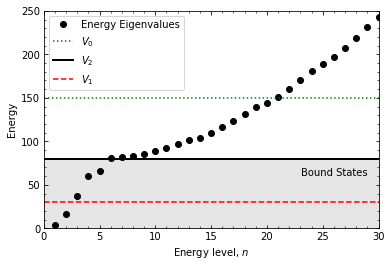

In [11]:
### BEGIN SOLUTION
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot()
n = np.arange(1, N)
x = n * h
ax.plot(n, E, 'ko', label='Energy Eigenvalues')
nmax = 30 # arbitrary choice to make a nice plot
ax.axhline(V0, color='g', ls=':', label='$V_0$')
ax.axhline(V2, color='k', ls='-', lw=2, label='$V_2$')
ax.axhline(V1, color='r', ls='--', label='$V_1$')
ax.set_xlim(0, nmax)
ax.set_ylim(0, 250)
ax.legend(loc='best')

# Shade and label the bound state region since this looks nice
ax.fill_between([0,nmax], V2, color='k', alpha=0.1)
ax.text(nmax-1, V2-10, 'Bound States', ha='right', va='top')
ax.set_xlabel('Energy level, $n$')
ax.set_ylabel('Energy')
ax.minorticks_on()
### END SOLUTION

### Probability Densities

Next we will look at the wave functions.  The magnitude of the wave function squared, $|\psi(x)|^2$, is a probability density.  We can use it to determine the probability of finding the particle in a given region.  Here we will produce two figures of the probability density.  In these figures include vertical lines at $a_0$, $a_1$, and $a_2$.  To not make these figures too busy you do not need to label these vertical lines.

##### Figures:

Produce the following figures and include them below.
1. Plot the probability density for all the states with $E_n<V_1$.
2. Plot the probability density for all the states with $V_1<E_n<V_2$.
3. **[Not required.]** It is also worthwhile to look at the probability density for states with $E_n>V_2$.  Our solution is not actually correct for these states.  Unbound states, called scattering states, have a continuous energy spectrum instead of the discrete one we have found.  Furthermore, we have forced $\psi(x)=0$ for all $x\ge 5a_0$ so we are not actually solving for scattering states.  Regardless, if we look at the probability density for slightly large values of $n$, for example $n=15$, we get a good idea of what scattering states look like. (For those familiar with quantum mechanics, these probability densities should look somewhat familiar.  They look like the results from your study of the scattering from finite potential wells for a plane wave sent in from the right.)

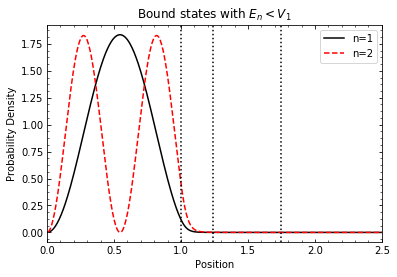

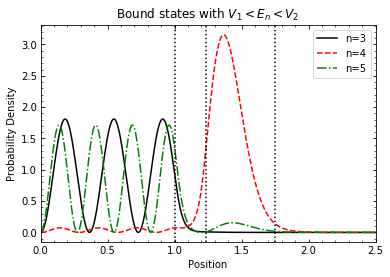

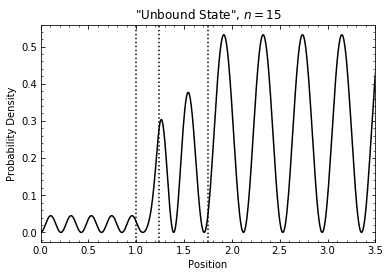

In [12]:
### BEGIN SOLUTION

# There are two states with En < V1 and three for V1 < En < V2.
# We could use the where function to find the states but for
# a figure we might as well do them by hand.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi[:,0]**2, 'k-', label='n=1')
ax.plot(x, psi[:,1]**2, 'r--', label='n=2')
ax.axvline(a0, color='k', ls=':')
ax.axvline(a1, color='k', ls=':')
ax.axvline(a2, color='k', ls=':')
ax.set_xlim(0, 2.5)
ax.set_xlabel('Position')
ax.set_ylabel('Probability Density')
ax.set_title('Bound states with $E_n<V_1$')
ax.legend(loc='best')
ax.minorticks_on()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi[:,2]**2, 'k-', label='n=3')
ax.plot(x, psi[:,3]**2, 'r--', label='n=4')
ax.plot(x, psi[:,4]**2, 'g-.', label='n=5')
ax.axvline(a0, color='k', ls=':')
ax.axvline(a1, color='k', ls=':')
ax.axvline(a2, color='k', ls=':')
ax.set_xlim(0, 2.5)
ax.set_xlabel('Position')
ax.set_ylabel('Probability Density')
ax.set_title('Bound states with $V_1<E_n<V_2$')
ax.legend(loc='best')
ax.minorticks_on()

# This plot is NOT required
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi[:,14]**2, 'k-', label='n=15')
ax.axvline(a0, color='k', ls=':')
ax.axvline(a1, color='k', ls=':')
ax.axvline(a2, color='k', ls=':')
ax.set_xlim(0, 3.5)
ax.set_xlabel('Position')
ax.set_ylabel('Probability Density')
ax.set_title('"Unbound State", $n=15$')
#ax.legend(loc='best')
ax.minorticks_on()

### END SOLUTION

### Probabilities

As you should see in your figures of the probability density, the particle has some probability of being in the classically forbidden regions (regions where the total energy of the particle is negative).  The probability of being found in a region is calculated by integrating the probability density over this region.  In other words, the probability of the particle being found in the region $a_0\le x\le a_1$ is given by

$$ P(a_0\le x\le a_1) = \int_{a_0}^{a_1} |\psi|^2 \mathrm{d}x. $$

Since we have tabulated our wave function, numerically this integral can be evaluated as a direct sum,

$$ \int |\psi(x)|^2 \mathrm{d}x \approx \sum_j |\psi(x_j)|^2 h . $$

Calculate and print the probability for finding the particle in each of the four different regions of the potential for the $n=5$ state, $\psi_5$.  Recall that $n$ labels the state, not the index in the array of eigenvectors you calculated!  Physically the particle **must be in one of the regions** so the sum of all the probabilities you calculated must equal one.  Verify this is true for the probabilities you calculate.  You should find, perhaps surprisingly, that the particle has a  probability of being in the classically forbidden region, $x>a_2$.

(*Note: Another way to compute the integral is to use funtionality within the interpolation module, `scipy.interpolate.InterpolatedUnivariateSpline`. The spline object this method returns has an integral() function you can use - feel free to explore this option instead of performing a sum.*)

In [35]:
### BEGIN SOLUTION

n = 5
prob = psi[:,n-1]**2
prob_spline = interp.InterpolatedUnivariateSpline(x, prob)
isp = np.zeros(4)
isp[0] = prob_spline.integral(0,a0)
isp[1] = prob_spline.integral(a0,a1)
isp[2] = prob_spline.integral(a1,a2)
isp[3] = prob_spline.integral(a2,x[-1]+h)
print(f"""Probabilities for n={n} state:
0  < x < a0 : {isp[0]}
a0 < x < a1 : {isp[1]}
a1 < x < a2 : {isp[2]}
     x > a2 : {isp[3]}
Total probability: {isp.sum()}""")

### END SOLUTION

Probabilities for n=5 state:
0  < x < a0 : 0.8873570167658201
a0 < x < a1 : 0.06570074813775777
a1 < x < a2 : 0.04528407444671106
     x > a2 : 0.0016487553399847366
Total probability: 0.9999905946902736


## Member Participation

See Lab 1 for instructions on turning in labs. In the following cell enter the names for each student in the group who partcipated in this lab.